In [608]:
import pandas as pd
from os import listdir
from os.path import join, isfile
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from scipy import stats
from collections import Counter
import pickle
import sys
import numpy as np
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
import statsmodels.formula.api as smf

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 20, 20

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from multiprocessing import Pool

In [609]:
%time
path = "../data/financial-news-dataset-master/20061020_20131126_bloomberg_news/"
news_dataset = []
news_article = {}
date_headlines = {}

for date in tqdm(listdir(path)):
    if not isfile(join(path, date)): 
        date_headlines[date] = listdir(join(path, date))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 29.1 µs


100%|██████████| 1945/1945 [00:22<00:00, 88.36it/s]


In [610]:
%time
count = 0
fraction = 20
news_dataset = []

for date, headlines in tqdm(date_headlines.items()):
    for headline in headlines: 
        if (count % fraction) == 0:
            with open('../data/financial-news-dataset-master/20061020_20131126_bloomberg_news/' + date + '/' + headline) as f:
                #news_dataset.append({'Date': date, 'Headlines': headline, 'Content': f.readlines()}, ignore_index= True)
                news_dataset.append({'Date': date, 'Headlines': headline, 'Content': f.readlines()})
        count += 1

  0%|          | 1/1944 [00:00<06:04,  5.33it/s]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 14.8 µs


100%|██████████| 1944/1944 [01:20<00:00, 24.20it/s]


In [611]:
news_dataset = pd.DataFrame(news_dataset)
#date_headlines = pd.DataFrame(date_headlines)

In [612]:
news_dataset.head()

,Content,Date,Headlines
0,"[-- \n, Ivory Coast Keeps Cocoa Export Tax Bel...",2011-10-06,ivory-coast-keeps-cocoa-export-tax-below-22-do...
1,"[-- \n, Trichet Says ECB to Offer Longer Loans...",2011-10-06,richet-says-ecb-to-offer-longer-loans-will-res...
2,"[-- \n, Saft Chief Says Infrastructure So Far ...",2011-10-06,saft-chief-says-infrastructure-so-far-proving-...
3,"[-- \n, South Africa Daybook: Mining Output, Z...",2011-10-06,south-africa-daybook-business-confidence-elect...
4,"[-- \n, U.S. Stock Options With Biggest Change...",2011-10-06,u-s-stock-options-with-biggest-changes-in-impl...


In [771]:
#flat_list = [item for sublist in l for item in sublist]

[news for sublist in list(news_dataset['Content']) for news in sublist]

['-- \n',
 'Ivory Coast Keeps Cocoa Export Tax Below 22%, Document Shows\n',
 '\n',
 '-- B y   B a u d e l a i r e   M i e u\n',
 '-- \n',
 '2011-10-06T15:14:20Z\n',
 '\n',
 '-- http://www.bloomberg.com/news/2011-10-06/ivory-coast-keeps-cocoa-export-tax-below-22-document-shows.html\n',
 'Export taxes on cocoa beans from\n',
 ' Ivory Coast , the world’s biggest producer of the chocolate\n',
 'ingredient, won’t exceed 22 percent of the international price\n',
 'this season, meeting a commitment to the  International Monetary\n',
 'Fund , according to a finance ministry document.  In the 2008-9 season taxes averaged 25.3 percent of\n',
 'international prices, the IMF said in a  document  posted on its\n',
 'website in November last year. While the country met the\n',
 'commitment in the season just ended, it had a change in\n',
 'government earlier this year.  The rate meets a demand by the International Monetary Fund\n',
 'and the World Bank to reform the Ivorian cocoa and coffee\n',
 'i

In [ ]:
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Content")
wordcloud_draw(news_dataset['Headlines'],'white')

Content


In [7]:
sentiment_list = pd.read_excel('../data/peripheral_data/inquirerbasic.xls')

In [7]:
sentiment_list.head()

,Entry,Source,Positiv,Negativ,Pstv,Affil,Ngtv,Hostile,Strong,Power,...,Anomie,NegAff,PosAff,SureLw,If,NotLw,TimeSpc,FormLw,Othtags,Defined
0,A,H4Lvd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DET ART,| article: Indefinite singular article--some o...
1,ABANDON,H4Lvd,NaN,Negativ,NaN,NaN,Ngtv,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SUPV,|
2,ABANDONMENT,H4,NaN,Negativ,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Noun,|
3,ABATE,H4Lvd,NaN,Negativ,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SUPV,|
4,ABATEMENT,Lvd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Noun,NaN


## Convert to InquirerCount

In [8]:
sentiment_list = sentiment_list[['Entry']].join(sentiment_list.iloc[:,2:184].fillna(0).replace(r'.', 1, regex=True))

In [9]:
sentiment_list['Word'] = sentiment_list['Entry'].str.split('#', expand = True)[[0]]

In [8]:
sentiment_list.loc[sentiment_list['Word'] == 'GAIN'].any().to_dict()

{'ABS': False,
 'ANI': False,
 'Abs@': False,
 'Academ': False,
 'Active': True,
 'AffGain': False,
 'AffLoss': False,
 'AffOth': False,
 'AffPt': False,
 'AffTot': False,
 'Affil': False,
 'Anomie': False,
 'Aquatic': False,
 'ArenaLw': False,
 'Arousal': False,
 'Begin': False,
 'BldgPt': False,
 'BodyPt': False,
 'CARD': False,
 'COLL': False,
 'COLOR': False,
 'COM': False,
 'Causal': False,
 'ComForm': False,
 'ComnObj': False,
 'Compare': False,
 'Complet': True,
 'DAV': False,
 'DIM': False,
 'DIST': False,
 'Decreas': False,
 'Doctrin': False,
 'ECON': True,
 'EMOT': False,
 'EVAL': False,
 'Econ@': True,
 'EndsLw': True,
 'EnlEnds': False,
 'EnlGain': False,
 'EnlLoss': False,
 'EnlOth': False,
 'EnlPt': False,
 'EnlTot': False,
 'Entry': True,
 'Eval@': False,
 'Exch': False,
 'Exert': False,
 'Exprsv': False,
 'FREQ': False,
 'Fail': False,
 'Fall': False,
 'Feel': False,
 'Female': False,
 'Fetch': False,
 'Finish': False,
 'Food': False,
 'FormLw': False,
 'Goal': True,
 '

In [15]:
date_sentiment = []
cnt = Counter()
limit_data = 365

for index, item in tqdm(news_dataset[-limit_data:].iterrows()):
    
    for headline in headlines:
        
        for word in headline.split('-'):
            
            for key, value in sentiment_list.loc[sentiment_list['Word'] == word.upper()].any().to_dict().items():
                
                if value == True: 
                    
                    cnt[key] += 1
            
        date_sentiment.append({date: dict(cnt.items())})

365it [51:43,  8.50s/it]


In [10]:
def inquirer_counter(item):
    
    
    date_sentiment = []
    cnt = Counter()
    temp_dict = {}
    
    #for item in tqdm(df):
    
    date = item[1]
    headlines = item[2]

    for word in headlines.split('-'):

        for key, value in sentiment_list.loc[sentiment_list['Word'] == word.upper()].any().to_dict().items():

            if value == True: 

                cnt[key] += 1

    #temp_dict = dict(cnt.items())
    temp_dict.update({'date': date, 'headline': headlines})
    temp_dict.update(dict(cnt.items()))
    cnt.clear()
    
    date_sentiment.append(temp_dict)
            
    return date_sentiment

## Breakdown of inquirer_counter function

In [603]:
{w:v for w,v in sentiment_list.loc[sentiment_list['Word'] == 'ACQUIRE'].to_dict(orient='records')[0].items() if v!=0}

{'Active': 1,
 'Entry': 'ACQUIRE#1',
 'Fetch': 1,
 'Strong': 1,
 'TrnGain': 1,
 'Word': 'ACQUIRE'}

In [604]:
sentiment_list.loc[sentiment_list['Word'] == 'ACQUIRE']

,Entry,Positiv,Negativ,Pstv,Affil,Ngtv,Hostile,Strong,Power,Weak,...,Nation,Anomie,NegAff,PosAff,SureLw,If,NotLw,TimeSpc,FormLw,Word
116,ACQUIRE#1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,ACQUIRE
117,ACQUIRE#2,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,ACQUIRE


In [613]:
p = Pool(4)
date_sentiment = p.map(inquirer_counter, news_dataset.values.tolist())

In [13]:
date_sentiment = [item[0] for item in date_sentiment]
date_sentiment = pd.DataFrame(date_sentiment).fillna(0)

In [129]:
del news_dataset

In [615]:
date_sentiment

[[{'COM': 2,
   'ComForm': 1,
   'ComnObj': 1,
   'ECON': 1,
   'Econ@': 1,
   'Entry': 6,
   'Food': 1,
   'FormLw': 1,
   'Hostile': 1,
   'IAV': 2,
   'Land': 1,
   'Means': 1,
   'Negativ': 1,
   'Ngtv': 1,
   'Object': 2,
   'PLACE': 1,
   'POLIT': 1,
   'Passive': 1,
   'SocRel': 1,
   'Space': 1,
   'TimeSpc': 1,
   'Travel': 1,
   'TrnLoss': 1,
   'WltOth': 2,
   'WltTot': 2,
   'Word': 6,
   'date': '2011-10-06',
   'headline': 'ivory-coast-keeps-cocoa-export-tax-below-22-document-shows'}],
 [{'Active': 2,
   'Affil': 2,
   'Arousal': 1,
   'COM': 3,
   'ComForm': 2,
   'ComnObj': 3,
   'ECON': 1,
   'EndsLw': 1,
   'Entry': 5,
   'FormLw': 2,
   'IAV': 4,
   'Legal': 1,
   'Object': 3,
   'Passive': 1,
   'Positiv': 1,
   'PowOth': 1,
   'PowTot': 1,
   'Pstv': 1,
   'SklOth': 1,
   'SklTot': 1,
   'SocRel': 1,
   'Strong': 2,
   'TranLw': 1,
   'TrnGain': 1,
   'Vary': 1,
   'Word': 5,
   'date': '2011-10-06',
   'headline': 'richet-says-ecb-to-offer-longer-loans-will-resume

In [614]:
{w:v for w,v in date_sentiment.loc[date_sentiment['date'] == '2011-10-06'].to_dict(orient='records')[0].items() if v!=0}

AttributeError: 'list' object has no attribute 'loc'

In [12]:
with open('../data/peripheral_data/date_sentiment.pkl', 'wb') as fp:
    pickle.dump(date_sentiment, fp)

In [ ]:
with open ('../data/peripheral_data/date_sentiment.pkl', 'rb') as fp:
    date_sentiment = pickle.load(fp)

## Read and Process QQQ ETF that tracks the Nasdaq 100

In [15]:
nasdaq = pd.read_csv('../data/ETFs/qqq.us.txt')

In [617]:
nasdaq.head()

,Date,Open,High,Low,Close,Volume,OpenInt,Close Slope,Close Slope Differential,bull,Open Slope,High Slope,Low Slope
0,1999-03-10,45.722,45.750,44.967,45.665,11700414,0,NaN,NaN,False,NaN,NaN,NaN
1,1999-03-11,45.994,46.260,44.988,45.880,21670048,0,NaN,NaN,False,NaN,NaN,NaN
2,1999-03-12,45.721,45.749,44.406,44.770,19553768,0,NaN,NaN,False,NaN,NaN,NaN
3,1999-03-15,45.101,46.103,44.625,46.052,14245348,0,NaN,NaN,False,NaN,NaN,NaN
4,1999-03-16,46.253,46.643,45.749,46.447,10971066,0,1.112308,NaN,True,0.229921,2.877309,1.152978


In [17]:
def get_slope(df):
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(df, range(len(df)))
    
    return slope

## The Slope of the Closing Price of the QQ ETF, calculated over 5 trading days

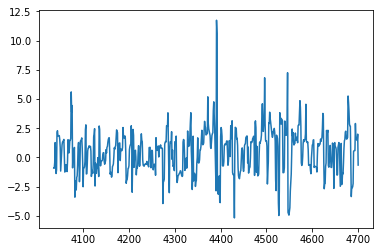

In [18]:
nasdaq['Close'].rolling(window=5,center=False,min_periods=5).apply(func = get_slope)[-665:].plot()

In [546]:
nasdaq['Close Slope'] = nasdaq['Close'].rolling(window=5,center=False,min_periods=5).apply(func = get_slope)
nasdaq['Open Slope'] = nasdaq['Open'].rolling(window=5,center=False,min_periods=5).apply(func = get_slope)
nasdaq['High Slope'] = nasdaq['High'].rolling(window=5,center=False,min_periods=5).apply(func = get_slope)
nasdaq['Low Slope'] = nasdaq['Low'].rolling(window=5,center=False,min_periods=5).apply(func = get_slope)

## The Difference in the slope between t and t-1 days

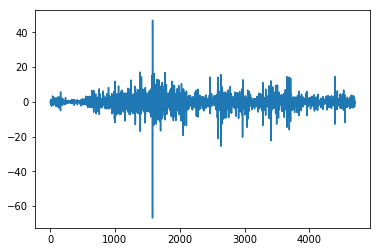

In [22]:
(nasdaq['Close Slope'] - nasdaq['Close Slope'].shift(1)).plot()

In [21]:
nasdaq['Close Slope Differential'] = (nasdaq['Close Slope'] - nasdaq['Close Slope'].shift(1))

In [634]:
nasdaq.tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Close Slope,Close Slope Differential,bull,Open Slope,High Slope,Low Slope
4696,2017-11-06,153.13,153.850,153.10,153.75,28685854,0,1.535100,-0.261293,True,1.811089,1.581342,1.144340
4697,2017-11-07,153.67,154.082,153.34,153.87,21285469,0,1.517837,-0.017263,True,1.687993,1.553483,1.269647
4698,2017-11-08,153.81,154.540,153.62,154.51,17326500,0,1.459258,-0.058580,True,1.902885,1.528673,1.253761
4699,2017-11-09,153.26,153.770,152.11,153.69,40554952,0,1.992826,0.533568,True,1.945213,1.978372,0.432357
4700,2017-11-10,153.36,153.800,153.06,153.68,20138114,0,-0.655738,-2.648564,False,0.154074,-0.996683,-1.011489


## Comparing the QQQ ETF Values, Slope and Slope Differential Values

In [636]:
nasdaq['Date'] = pd.to_datetime(nasdaq['Date'])
nasdaq = nasdaq.set_index('Date')

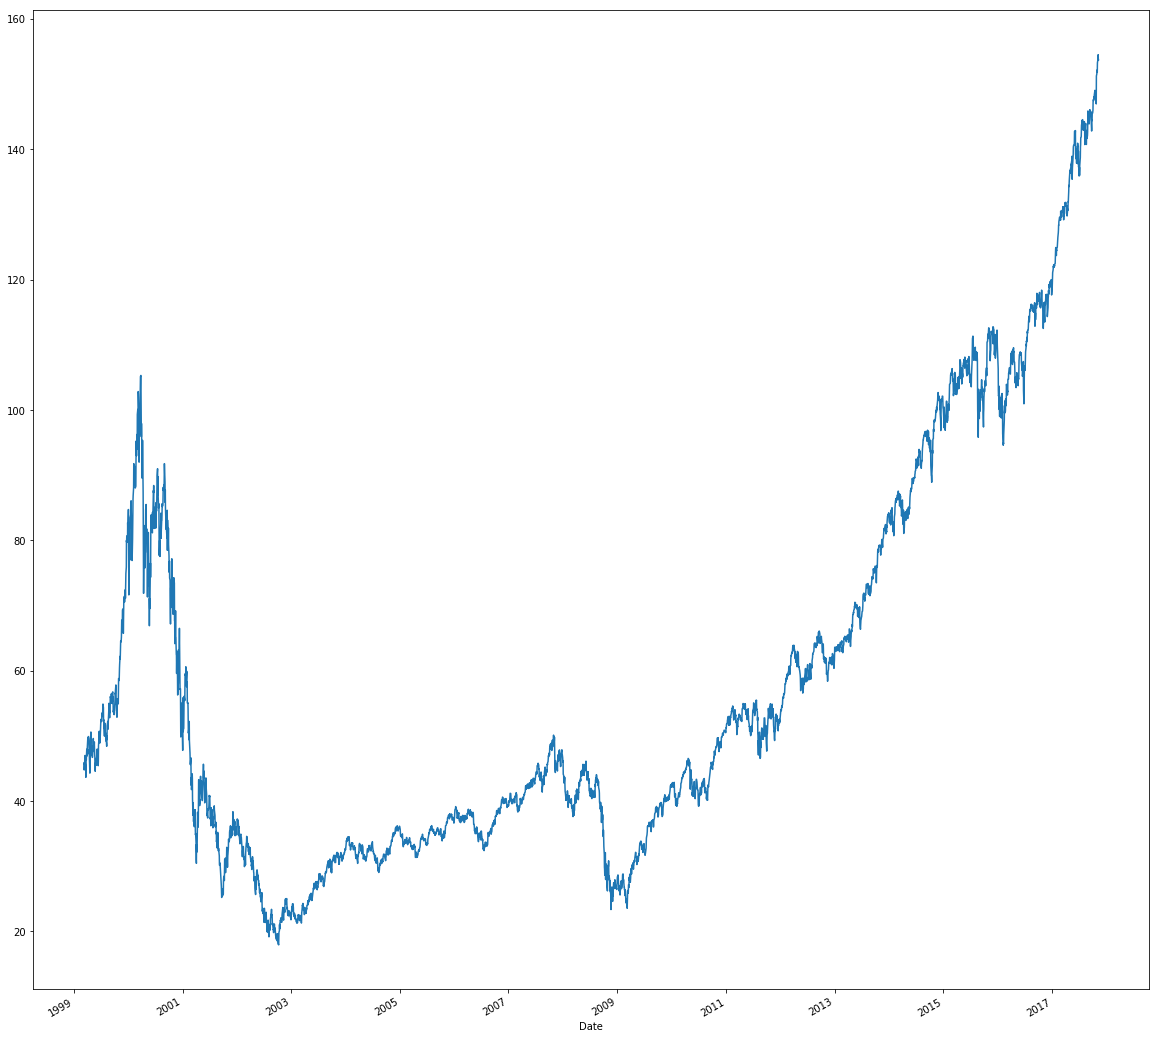

In [640]:
plot = nasdaq['Close'].plot()
plot.get_figure().savefig("qqq.png")

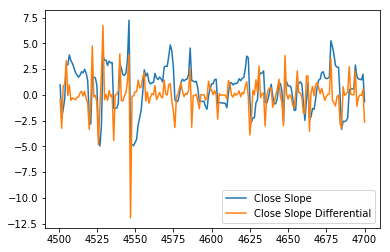

In [24]:
nasdaq.tail(200)[['Close Slope', 'Close Slope Differential']].plot()

In [27]:
nasdaq['bull'] = nasdaq['Close Slope'] > 0

## Map InquirerCount to QQQ ETF; i.e. Each date is broken down to Sentiment Counts

In [31]:
date_sentiment['date'] = pd.to_datetime(date_sentiment['date'])

In [547]:
nasdaq['Date'] = pd.to_datetime(nasdaq['Date'])

In [47]:
date_sentiment = date_sentiment.groupby('date').mean()

In [48]:
date_sentiment.head()

,ABS,ANI,Abs@,Academ,Active,AffGain,AffLoss,AffOth,AffPt,AffTot,...,WlbPt,WlbTot,WltOth,WltPt,WltTot,WltTran,Word,Work,Yes,You
date,,,,,,,,,,,,,,,,,,,,,
2006-10-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
2006-10-30,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0
2006-11-01,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,2.0,1.0,5.0,0.0,0.0,0.0
2006-11-13,1.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,0.0
2006-11-20,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,2.0,1.0,6.0,0.0,0.0,0.0


In [37]:
nasdaq.tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Close Slope,Close Slope Differential,bull
4696,2017-11-06,153.13,153.850,153.10,153.75,28685854,0,1.535100,-0.261293,True
4697,2017-11-07,153.67,154.082,153.34,153.87,21285469,0,1.517837,-0.017263,True
4698,2017-11-08,153.81,154.540,153.62,154.51,17326500,0,1.459258,-0.058580,True
4699,2017-11-09,153.26,153.770,152.11,153.69,40554952,0,1.992826,0.533568,True
4700,2017-11-10,153.36,153.800,153.06,153.68,20138114,0,-0.655738,-2.648564,False


In [548]:
merger = date_sentiment.merge(nasdaq, how='left', left_index = True, right_on = 'Date')

In [549]:
merger = merger.set_index('Date')

In [643]:
merger

,ABS,ANI,Abs@,Academ,Active,AffGain,AffLoss,AffOth,AffPt,AffTot,...,Low,Close,Volume,OpenInt,CloseSlope,CloseSlopeDifferential,bull,OpenSlope,HighSlope,LowSlope
Date,,,,,,,,,,,,,,,,,,,,,
2006-10-20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,37.809,38.135,116136535.0,0.0,-4.308868,0.665084,False,-4.652365,-6.793877,-4.106005
2006-10-30,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,38.188,38.569,114432024.0,0.0,1.792000,0.792157,True,1.349647,4.911219,7.300152
2006-11-01,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,37.976,38.135,164049904.0,0.0,-3.402973,-3.257204,False,0.726592,-10.161323,-4.463475
2006-11-13,1.000000,0.000000,0.000000,1.000000,2.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,39.037,39.464,98192406.0,0.0,5.229982,-1.516541,True,3.726572,4.863121,7.457352
2006-11-20,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,39.960,40.306,118051228.0,0.0,9.051713,4.370242,True,4.461471,6.174466,3.967531
2006-12-12,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,39.549,39.765,122242536.0,0.0,-3.243881,0.470988,False,-2.538386,-9.471212,-5.131627
2007-02-02,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,39.944,40.140,108013250.0,0.0,6.212800,-0.211018,True,4.174153,5.596165,5.147352
2007-03-08,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,38.943,39.058,133002764.0,0.0,3.944905,5.016457,True,2.781467,3.598997,4.399278
2007-03-20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,39.309,39.645,86574357.0,0.0,4.414845,0.206032,True,5.137673,5.922378,3.825110


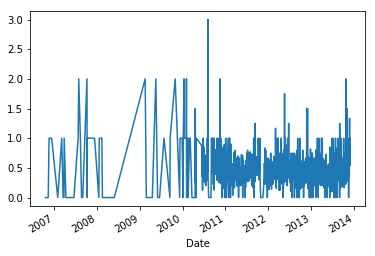

In [65]:
merger['Positiv'].plot()

## Comaparing the raw value of the QQQ ETF and mean value of sentiments for that day

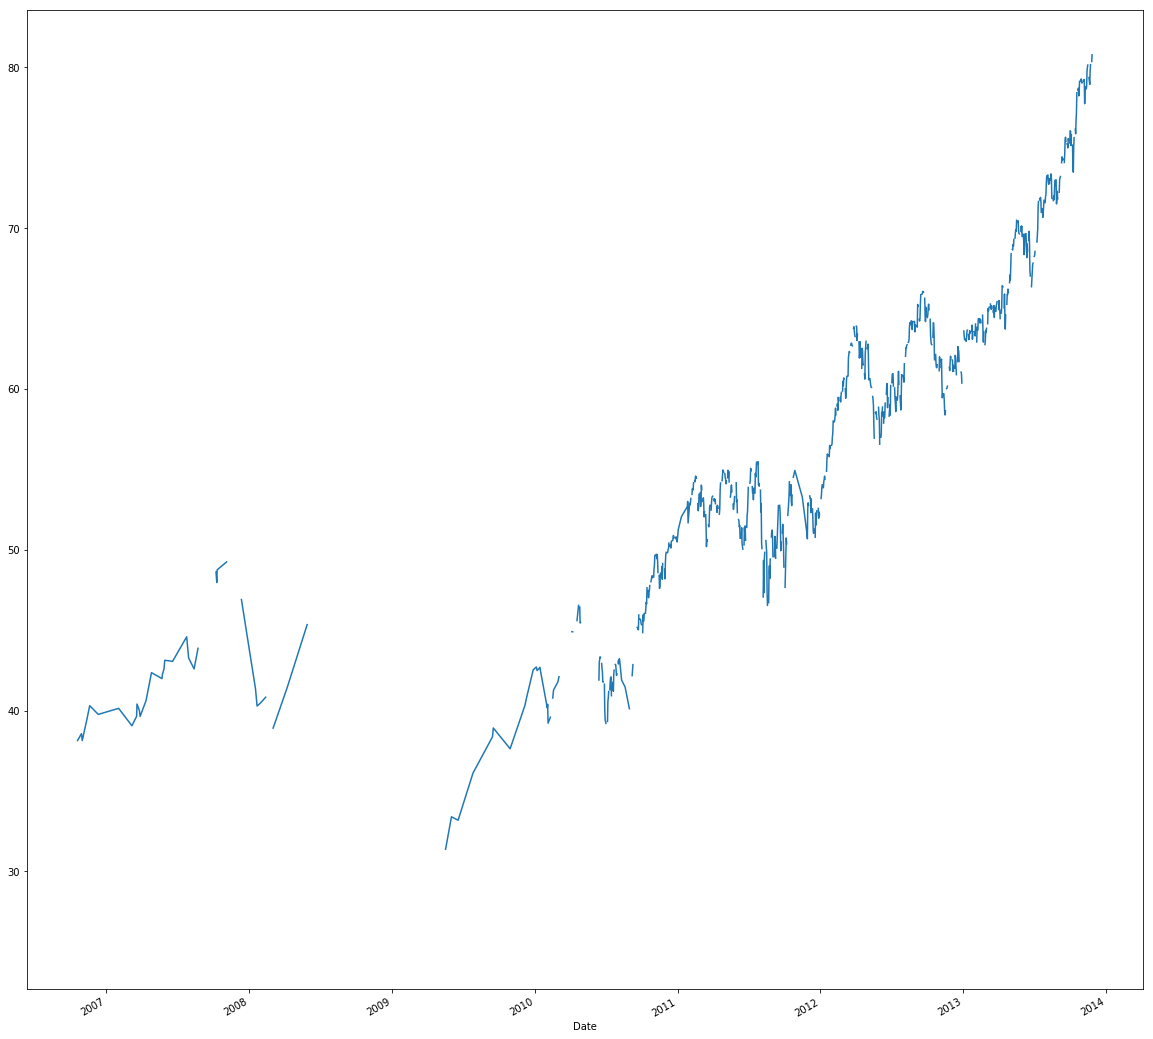

In [625]:
plot = merger['Close'].plot()

plot.get_figure().savefig("qqq.png")


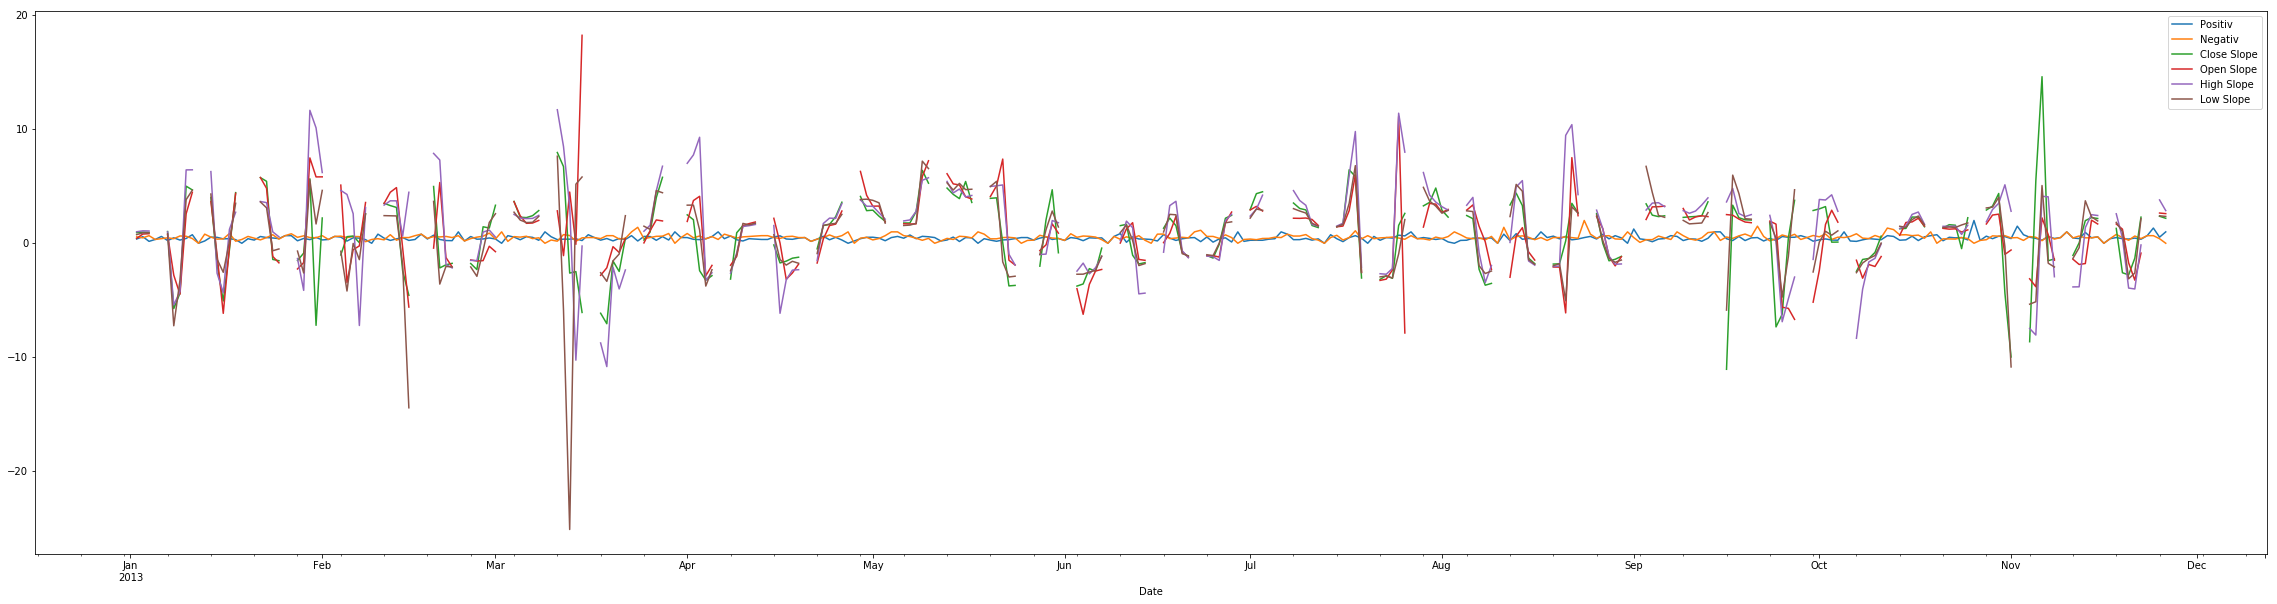

In [551]:
merger.iloc[merger.index>'2013'][['Positiv', 'Negativ', 'Close Slope', 'Open Slope', 'High Slope', 'Low Slope']].plot()

In [90]:
merger.iloc[merger.index>'2013'][['Positiv', 'Negativ']].corr()

,Positiv,Negativ
Positiv,1.000000,-0.007026
Negativ,-0.007026,1.000000


In [99]:
merger.iloc[merger.index>'2013'][['Positiv', 'Negativ','Close Slope', 'Close Slope Differential']]

,Positiv,Negativ,Close Slope,Close Slope Differential
Date,,,,
2013-01-02,0.375000,0.562500,0.930774,1.449665
2013-01-03,0.578947,0.473684,0.974542,0.043768
2013-01-04,0.166667,0.666667,0.953991,-0.020551
2013-01-05,0.333333,0.333333,NaN,NaN
2013-01-06,0.600000,0.400000,NaN,NaN
2013-01-07,0.238095,0.476190,1.030233,0.076242
2013-01-08,0.480000,0.400000,-5.724951,-6.755185
2013-01-09,0.280000,0.640000,-4.381753,1.343198
2013-01-10,0.423077,0.615385,5.008675,9.390428


## To Do

- Remove Weekends
- Tease out correlations
- Apply Naive Bayes
- Apply LSTM

## Scatter Plot of Positve and Negative Mean Sentiments

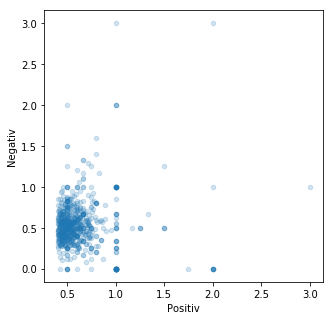

In [731]:
rcParams['figure.figsize'] = 5, 5
plot = merger.loc[merger['Positiv'] > 0.4][['Positiv', 'Negativ']].plot.scatter('Positiv', 'Negativ', alpha = 0.2)
plot.get_figure().savefig("Negativ_positiv.png")

In [718]:
merger.loc[merger['Positiv'] > 0.6][['Positiv', 'Negativ', 'HighSlope', 'LowSlope']].corr()

,Positiv,Negativ,HighSlope,LowSlope
Positiv,1.000000,-0.042278,-0.086336,-0.064992
Negativ,-0.042278,1.000000,0.029277,0.114718
HighSlope,-0.086336,0.029277,1.000000,0.680456
LowSlope,-0.064992,0.114718,0.680456,1.000000


## Notes

- Negative correlation appears to be stronger at extremes, which appears to check in intuitively
- Filter by strong values maybe?

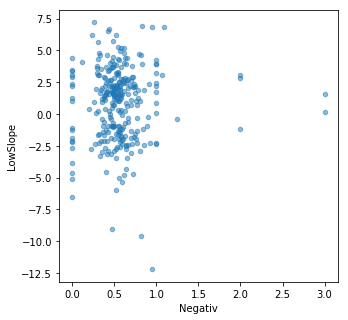

In [728]:
rcParams['figure.figsize'] = 5, 5
plot = merger.loc[merger['Positiv'] > 0.5].plot.scatter('Negativ', 'LowSlope', alpha = 0.5)
plot.get_figure().savefig("low_negativ.png")

## Correlations of General Inquirer Sentiments with respect to Slope of the 5 day Close Price and it's one day differential.

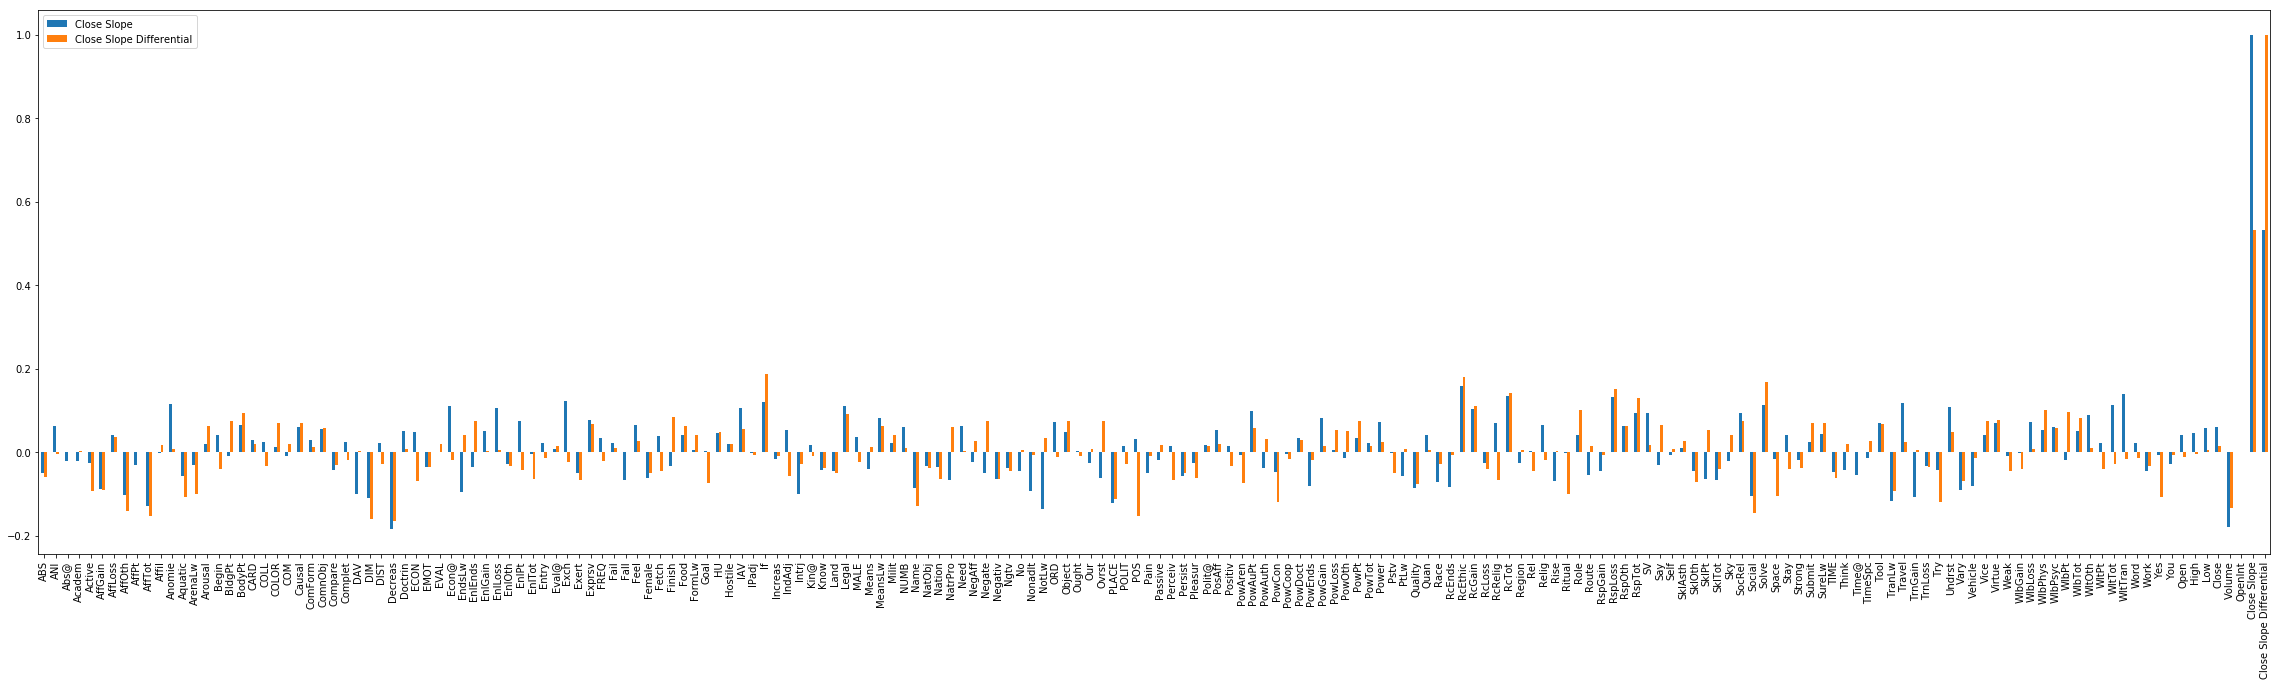

In [125]:
merger.iloc[merger.index>'2013'].corr()[['Close Slope', 'Close Slope Differential']].plot.bar()

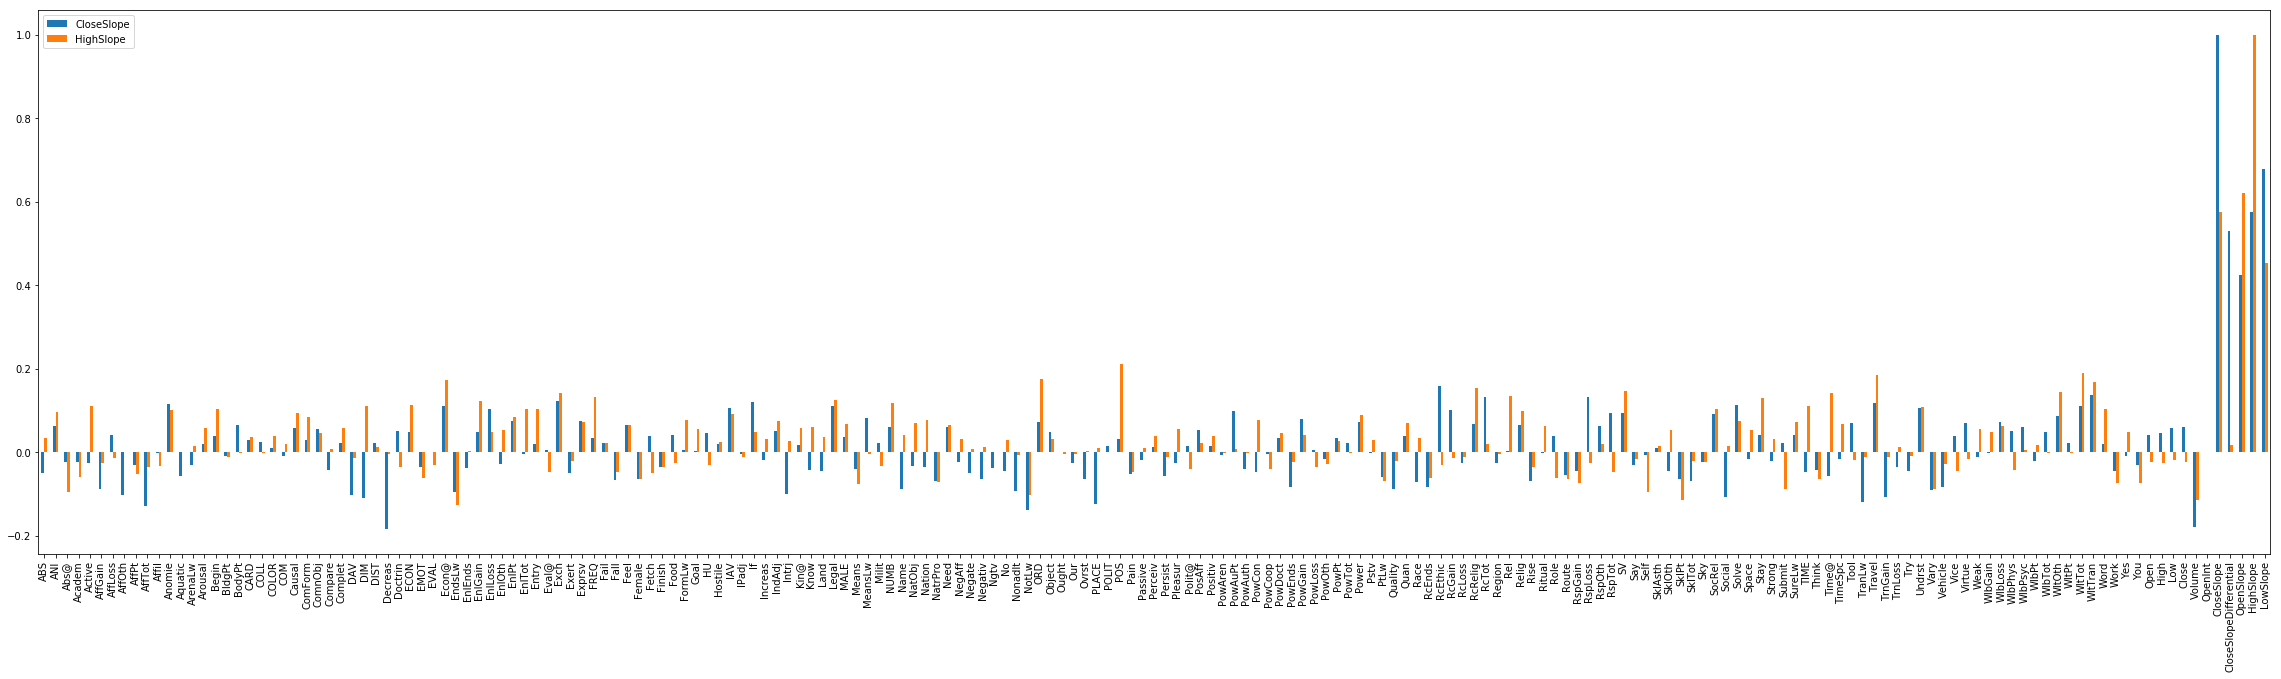

In [647]:
rcParams['figure.figsize'] = 40, 10
merger.iloc[merger.index>'2013'].corr()[['CloseSlope', 'HighSlope']].plot.bar()

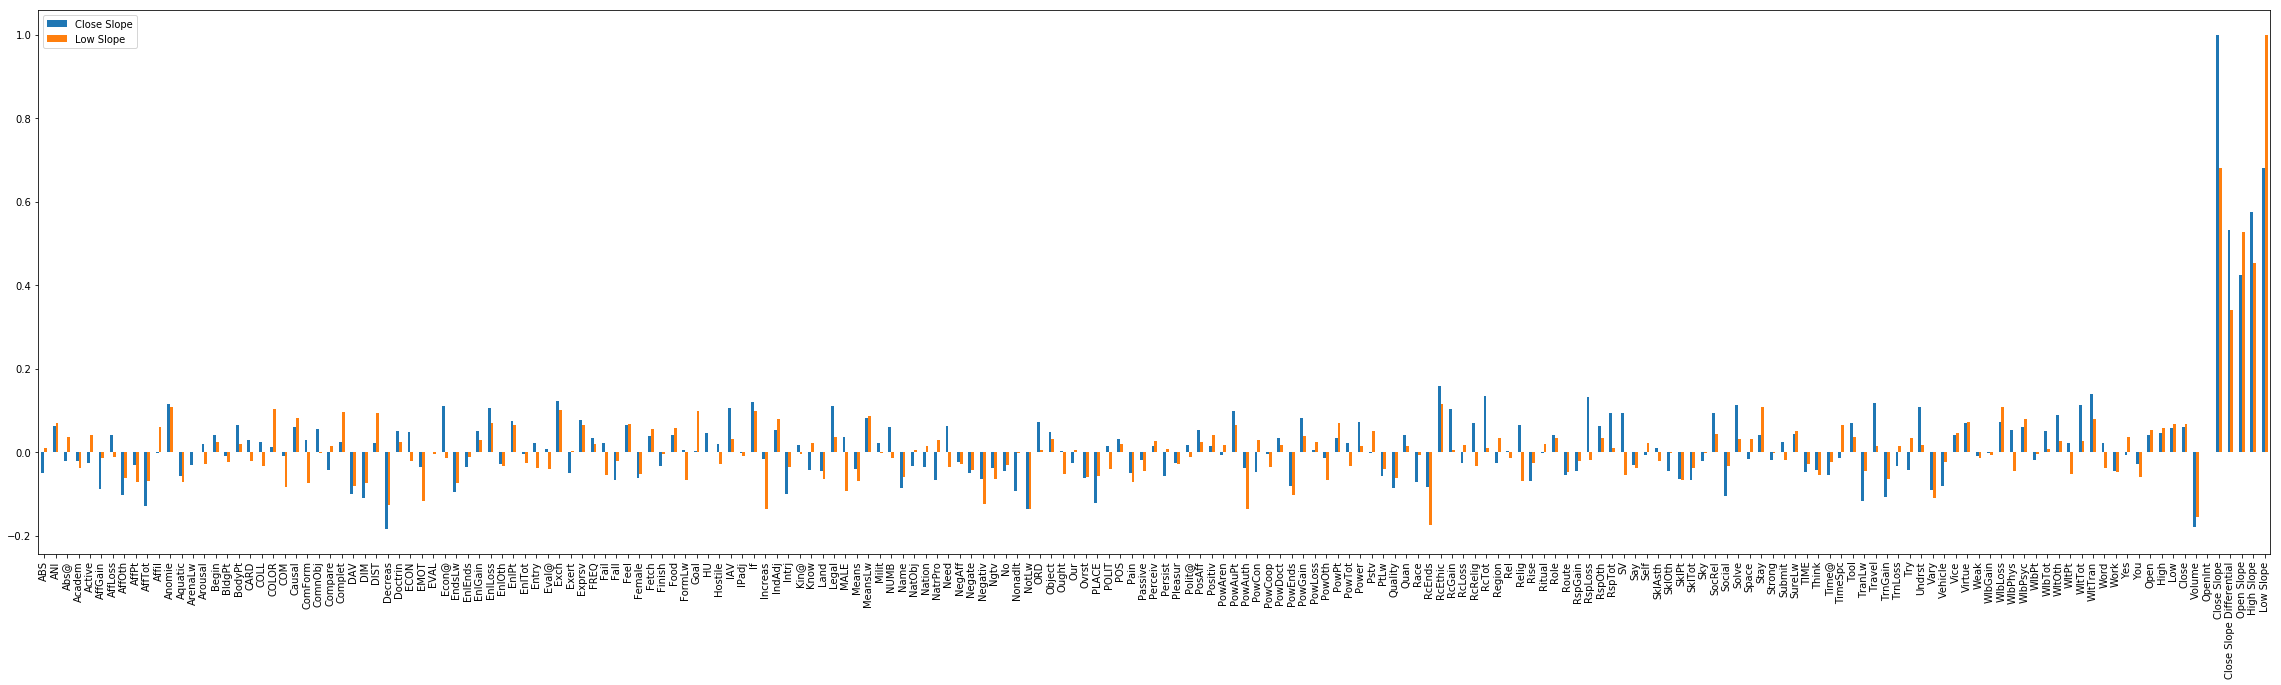

In [566]:
rcParams['figure.figsize'] = 40, 10
merger.iloc[merger.index>'2013'].corr()[['Close Slope', 'Low Slope']].plot.bar()

In [706]:
slope_correlations = merger.iloc[merger.index>'2013'].corr()[['CloseSlope', 'HighSlope', 'LowSlope', 'OpenSlope']]

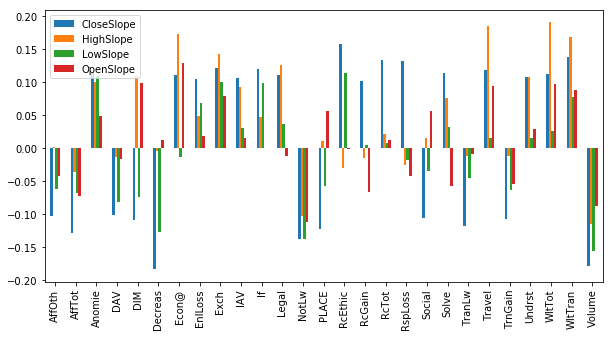

In [707]:
rcParams['figure.figsize'] = 10, 5
plot = slope_correlations.loc[((slope_correlations['CloseSlope'] > 0.1) | (slope_correlations['CloseSlope'] < -0.1))\
                            & (slope_correlations['CloseSlope'] < 0.4)].plot.bar()

plot.get_figure().savefig("correlations.png")

## Notes

Weak Negative Correlation Between:

Decreas* = Other process or change words. Words like depreciate, dwindle etc
NotLw   = words "that show the denial of one sort or another."
AffTot* = Affection is the valuing of love and friendship
Place   = References to places, locations and routes between them. (?)
TranLw  = Words of transaction or exchange in a broad sense, but not necessarily of gain or loss.
DIM*    = Words relating to space and dimension; like big, breif, broad, considerable, endless, enormous
POS     = Words for position; Words like Adjascent, centre, follow, high
TrnGain = General words of accomplishment; words like additon, acquire, affirm, bestow, broke, caught, clearence (?)
Social* = Words for created locations that typically provide for social interaction and occupy limited space
Try*     = Indicating activities taken to reach a goal
PowCon   = Power conflict

Weak Positive Correlation Between:

RcEthic* = words of values concerning the social order.
WltTran  = Wealth transaction, 53 words for pursuit of wealth, such as buying and selling.
Solve    = words (mostly verbs) referring to the mental processes associated with problem solving.
RcGain*  = Rectitude gain, 30 words such as worship and forgiveness.
RcTot*   = Rectitude is concerned with moral value
RspLoss* = Words for the losing of respect, such as shame (?)
Exch     = Words concerned with buying, selling and trading
if*      = Words "denoting feelings of uncertainty, doubt and vagueness."
Travel   = Words for all physical movement and travel from one place to another in a horizontal plane)
Anomie   = Words that usually show "a negation of value preference", nihilism, disappointment and futility.

Also note that the volume is negatively correlated with slope. 

## Machine Learning yay - Multinomial NB

In [218]:
merger['bull'] = merger['Close Slope Differential'] > 0

In [219]:
train, test = train_test_split(merger.dropna(),test_size = 0.25)

In [220]:
from sklearn.naive_bayes import MultinomialNB

train_X = train.iloc[:,0:-9]
train_Y = train.iloc[:,-1].astype('int')

clf = MultinomialNB(alpha = 1)
clf.fit(train_X, train_Y)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [221]:
test_X = test.iloc[:,0:-9]
test_Y = test.iloc[:,-1].astype('int')

clf.score(test_X, test_Y)

0.5533980582524272

## Bernoulli Naive Bayes

In [222]:
from sklearn.naive_bayes import BernoulliNB

train_X = train.iloc[:,0:-9]
train_Y = train.iloc[:,-1].astype('int')

clf = BernoulliNB(alpha = 1, binarize = 1)
clf.fit(train_X, train_Y)

BernoulliNB(alpha=1, binarize=1, class_prior=None, fit_prior=True)

In [223]:
test_X = test.iloc[:,0:-9]
test_Y = test.iloc[:,-1].astype('int')

clf.score(test_X, test_Y)

0.5533980582524272

## Bernoulli Naive Bayes over multiple shifts

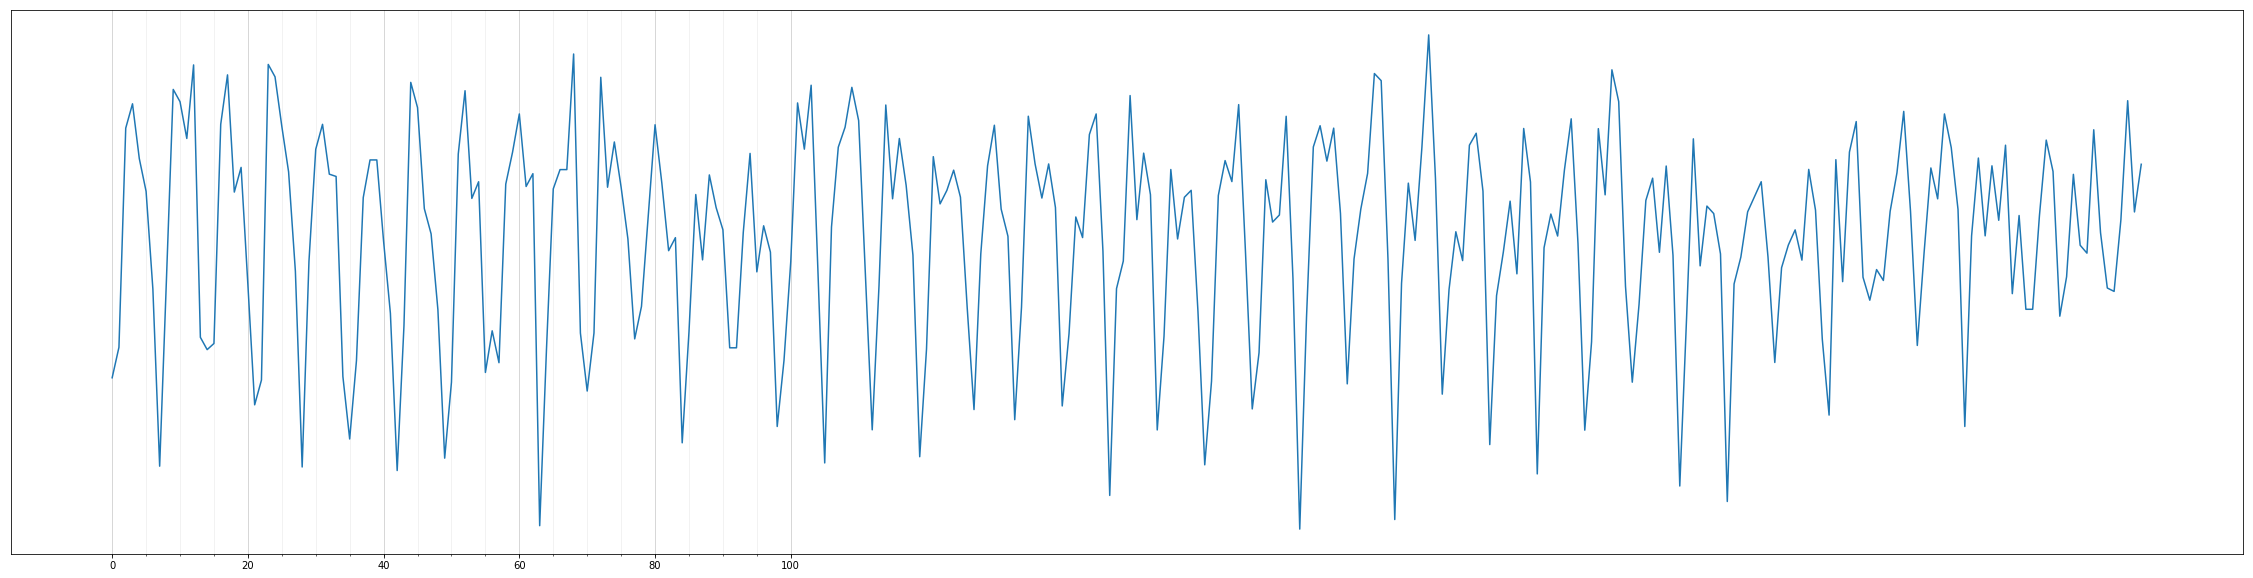

In [243]:
from sklearn.naive_bayes import BernoulliNB

future_accuracy = []
range_val = 300 

for future in range(range_val):

    merger['bull_tomorrow'] = merger['bull'].shift(-future)
    train, test = train_test_split(merger.dropna(),test_size = 0.35)

    train_X = train.iloc[:,0:-9]
    train_Y = train.iloc[:,-1].astype('int')

    clf = BernoulliNB(alpha = 1, binarize = 1)
    clf.fit(train_X, train_Y)

    test_X = test.iloc[:,0:-9]
    test_Y = test.iloc[:,-1].astype('int')

    future_accuracy.append(clf.score(test_X, test_Y))


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, 101, 20)
minor_ticks = np.arange(0, 101, 5)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

#plt.show()

#plt.grid(which='both')
plt.plot(range(range_val), future_accuracy)

A decreasing accuracy as we attempt to predict further into the future is *not* observed. The chart appears to be fairly random. Although, there does appear to be a pattern here. Let's investigate

In [254]:
def autocorr(x, t=1):
    return np.corrcoef(np.array([x[0:len(x)-t], x[t:len(x)]]))

autocorr(future_accuracy, 7)

array([[1.        , 0.77339569],
       [0.77339569, 1.        ]])

There is a strong 7-interval periodicity in the accuracy of the model. Predicting the Bull/Bear of every t + 7th day, given the sentiments of t, is surprisingly accurate. Maybe autocorrelation in the slope differential needs to be investigated?

## Investigating periodicity in slopes

In [302]:
corrs = []
for t in range(10):
    corrs.append(autocorr(np.array(merger['Close Slope Differential'].dropna()), t)[0][1])

In [305]:
corrs = []
for t in range(10):
    corrs.append(autocorr(np.array(merger['Close Slope'].dropna()), t)[0][1])


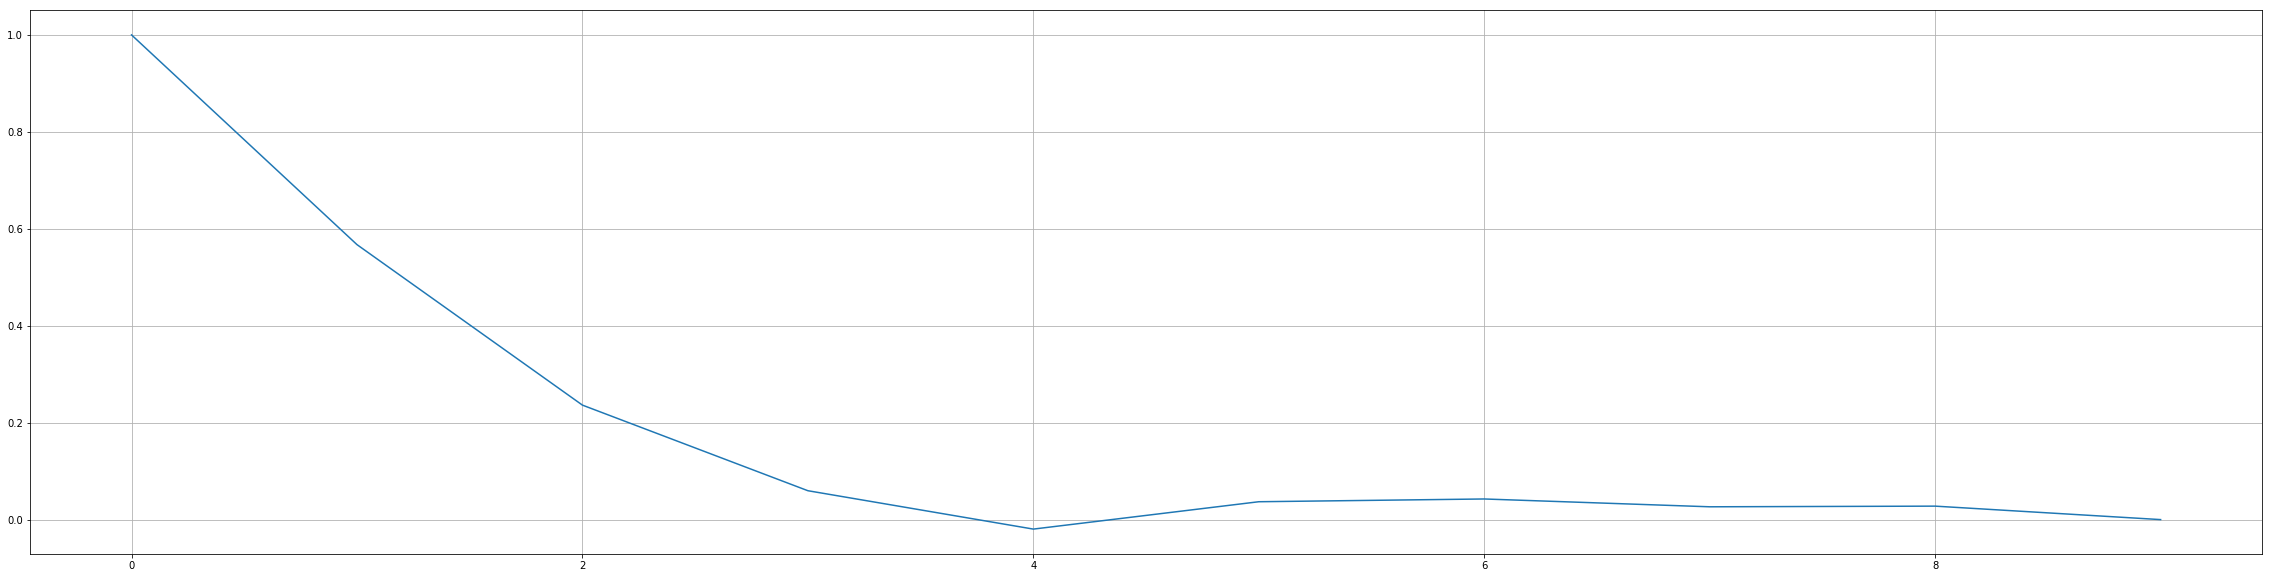

In [306]:
plt.grid(which='both')
plt.plot(range(10), corrs)

## Multivariate Regression

In [441]:
merger.head()

,ABS,ANI,Abs@,Academ,Active,AffGain,AffLoss,AffOth,AffPt,AffTot,...,Open,High,Low,Close,Volume,OpenInt,Close Slope,Close Slope Differential,bull,bull_tomorrow
Date,,,,,,,,,,,,,,,,,,,,,
2006-10-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,38.172,38.210,37.809,38.135,116136535.0,0.0,-4.308868,0.665084,True,True
2006-10-30,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,38.280,38.725,38.188,38.569,114432024.0,0.0,1.792000,0.792157,True,False
2006-11-01,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,38.799,38.835,37.976,38.135,164049904.0,0.0,-3.402973,-3.257204,False,True
2006-11-13,1.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,...,39.083,39.529,39.037,39.464,98192406.0,0.0,5.229982,-1.516541,False,False
2006-11-20,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,40.094,40.386,39.960,40.306,118051228.0,0.0,9.051713,4.370242,True,False


In [451]:
print(smf.ols(formula="Close ~ Open", data=merger).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 3.713e+05
Date:                Mon, 16 Apr 2018   Prob (F-statistic):               0.00
Time:                        15:41:40   Log-Likelihood:                -614.52
No. Observations:                 880   AIC:                             1233.
Df Residuals:                     878   BIC:                             1243.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0157      0.096      0.163      0.8

In [448]:
len(merger)

1247

## Rename Column names for Statsmodel

In [568]:
merger = merger.rename({'Close Slope Differential': 'CloseSlopeDifferential',
                        'Close Slope':'CloseSlope',
                        'Open Slope': 'OpenSlope',
                        'High Slope': 'HighSlope',
                        'Low Slope': 'LowSlope'}, axis = 1)

In [762]:
print(smf.ols(formula="CloseSlope ~ "
                      + "Decreas + NotLw + AffTot + PLACE + TranLw + DIM + POS + TrnGain + Social + Try + PowCon +"
                      + "RcEthic + WltTran + Solve + RcGain + RcTot + RspLoss + If + Exch + Travel + Anomie +"
                      + "Begin", data=merger).fit().summary())

                            OLS Regression Results                            
Dep. Variable:             CloseSlope   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     2.916
Date:                Wed, 18 Apr 2018   Prob (F-statistic):           9.22e-06
Time:                        05:44:55   Log-Likelihood:                -2280.8
No. Observations:                 880   AIC:                             4608.
Df Residuals:                     857   BIC:                             4718.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3997      0.373      1.072      0.2

In [763]:
print(smf.ols(formula="CloseSlope ~ "
                      + "AffTot + PLACE + TranLw + Social + Try + WltTran + Solve + Exch + Travel", data=merger).fit().summary())

                            OLS Regression Results                            
Dep. Variable:             CloseSlope   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     4.464
Date:                Wed, 18 Apr 2018   Prob (F-statistic):           9.64e-06
Time:                        05:51:18   Log-Likelihood:                -2292.7
No. Observations:                 880   AIC:                             4605.
Df Residuals:                     870   BIC:                             4653.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6597      0.337      1.958      0.0

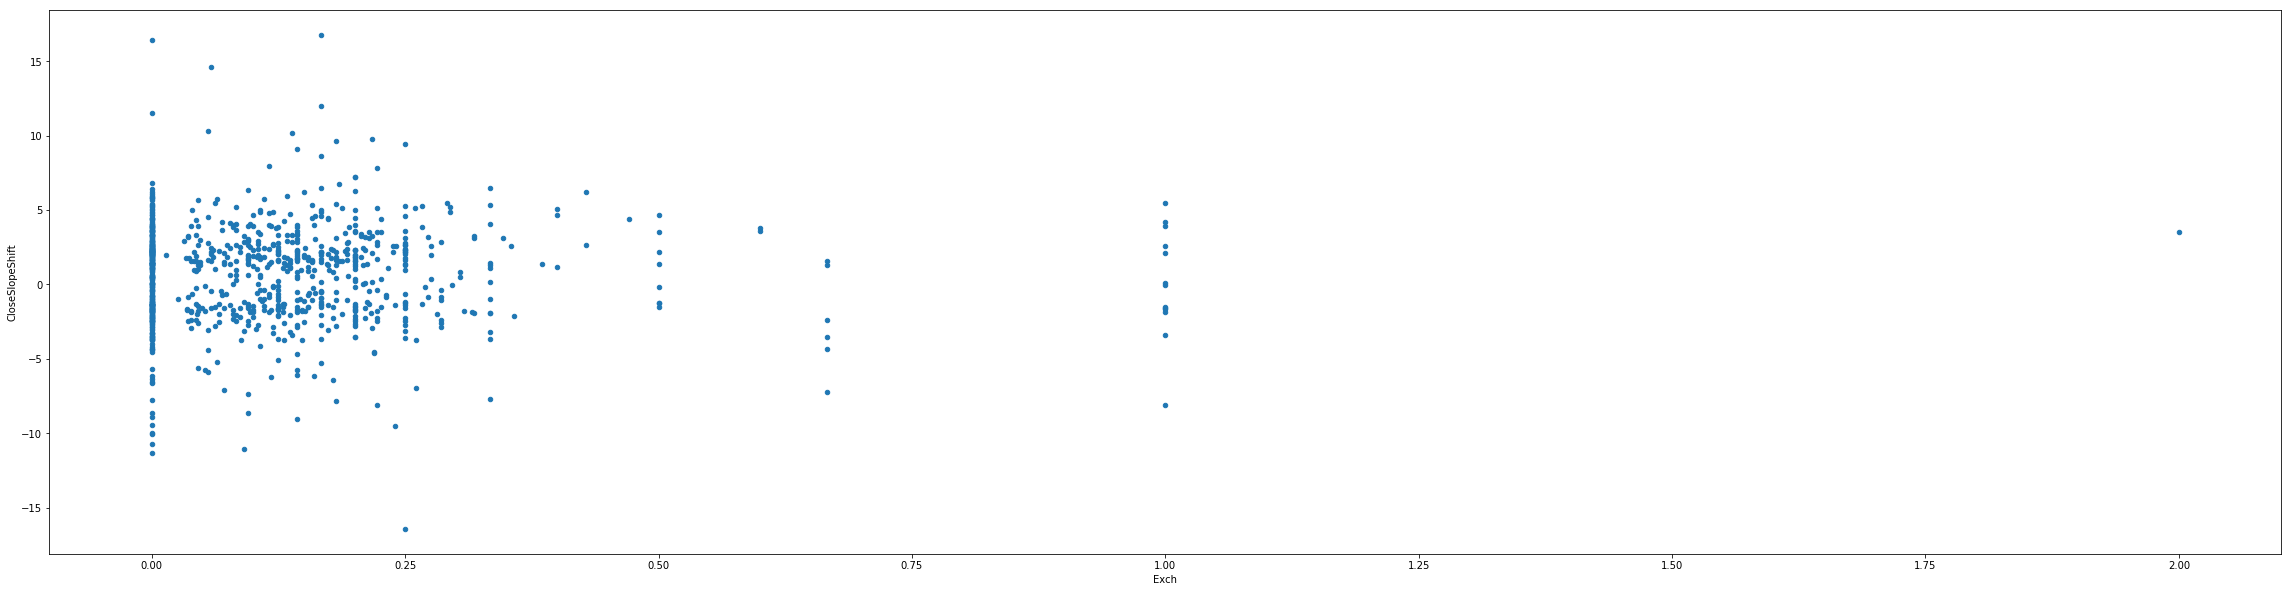

In [522]:
merger.plot.scatter(x = 'Exch', y = 'CloseSlopeShift')

In [504]:
[print(i) for i in merger.columns]

ABS
ANI
Abs@
Academ
Active
AffGain
AffLoss
AffOth
AffPt
AffTot
Affil
Anomie
Aquatic
ArenaLw
Arousal
Begin
BldgPt
BodyPt
CARD
COLL
COLOR
COM
Causal
ComForm
ComnObj
Compare
Complet
DAV
DIM
DIST
Decreas
Doctrin
ECON
EMOT
EVAL
Econ@
EndsLw
EnlEnds
EnlGain
EnlLoss
EnlOth
EnlPt
EnlTot
Entry
Eval@
Exch
Exert
Exprsv
FREQ
Fail
Fall
Feel
Female
Fetch
Finish
Food
FormLw
Goal
HU
Hostile
IAV
IPadj
If
Increas
IndAdj
Intrj
Kin@
Know
Land
Legal
MALE
Means
MeansLw
Milit
NUMB
Name
NatObj
Nation
NatrPro
Need
NegAff
Negate
Negativ
Ngtv
No
Nonadlt
NotLw
ORD
Object
Ought
Our
Ovrst
PLACE
POLIT
POS
Pain
Passive
Perceiv
Persist
Pleasur
Polit@
PosAff
Positiv
PowAren
PowAuPt
PowAuth
PowCon
PowCoop
PowDoct
PowEnds
PowGain
PowLoss
PowOth
PowPt
PowTot
Power
Pstv
PtLw
Quality
Quan
Race
RcEnds
RcEthic
RcGain
RcLoss
RcRelig
RcTot
Region
Rel
Relig
Rise
Ritual
Role
Route
RspGain
RspLoss
RspOth
RspTot
SV
Say
Self
SklAsth
SklOth
SklPt
SklTot
Sky
SocRel
Social
Solve
Space
Stay
Strong
Submit
SureLw
TIME
Think
Time@
TimeSpc


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

## Scatter Plots of the highest and lowest Regression Coefficients

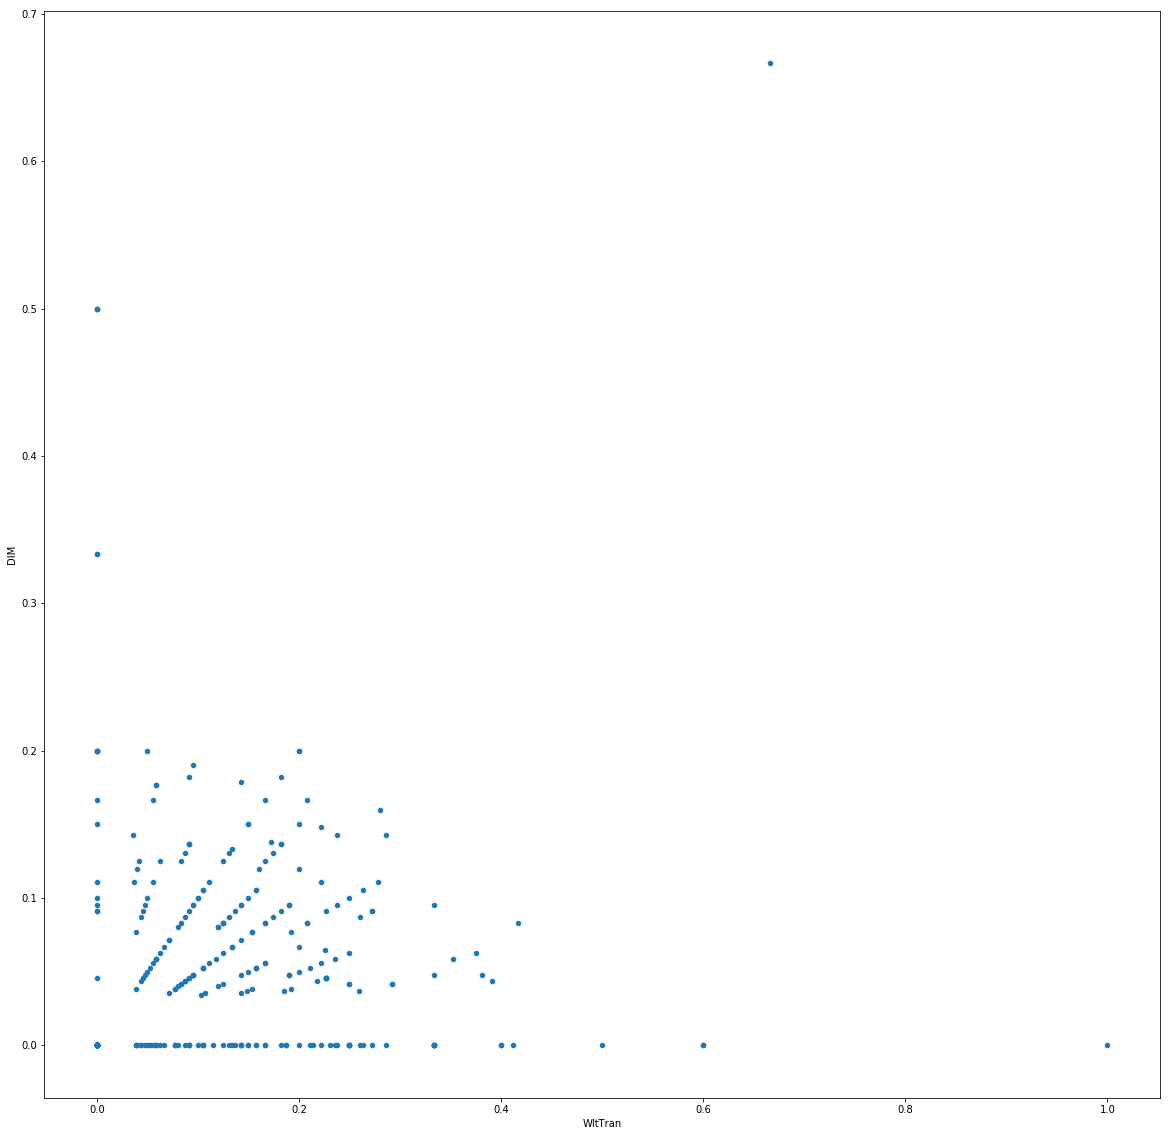

In [556]:
merger.iloc[merger.index>'2013'].plot.scatter('WltTran', 'DIM')

## Scatter Plots of Statistically Significant Coefficients

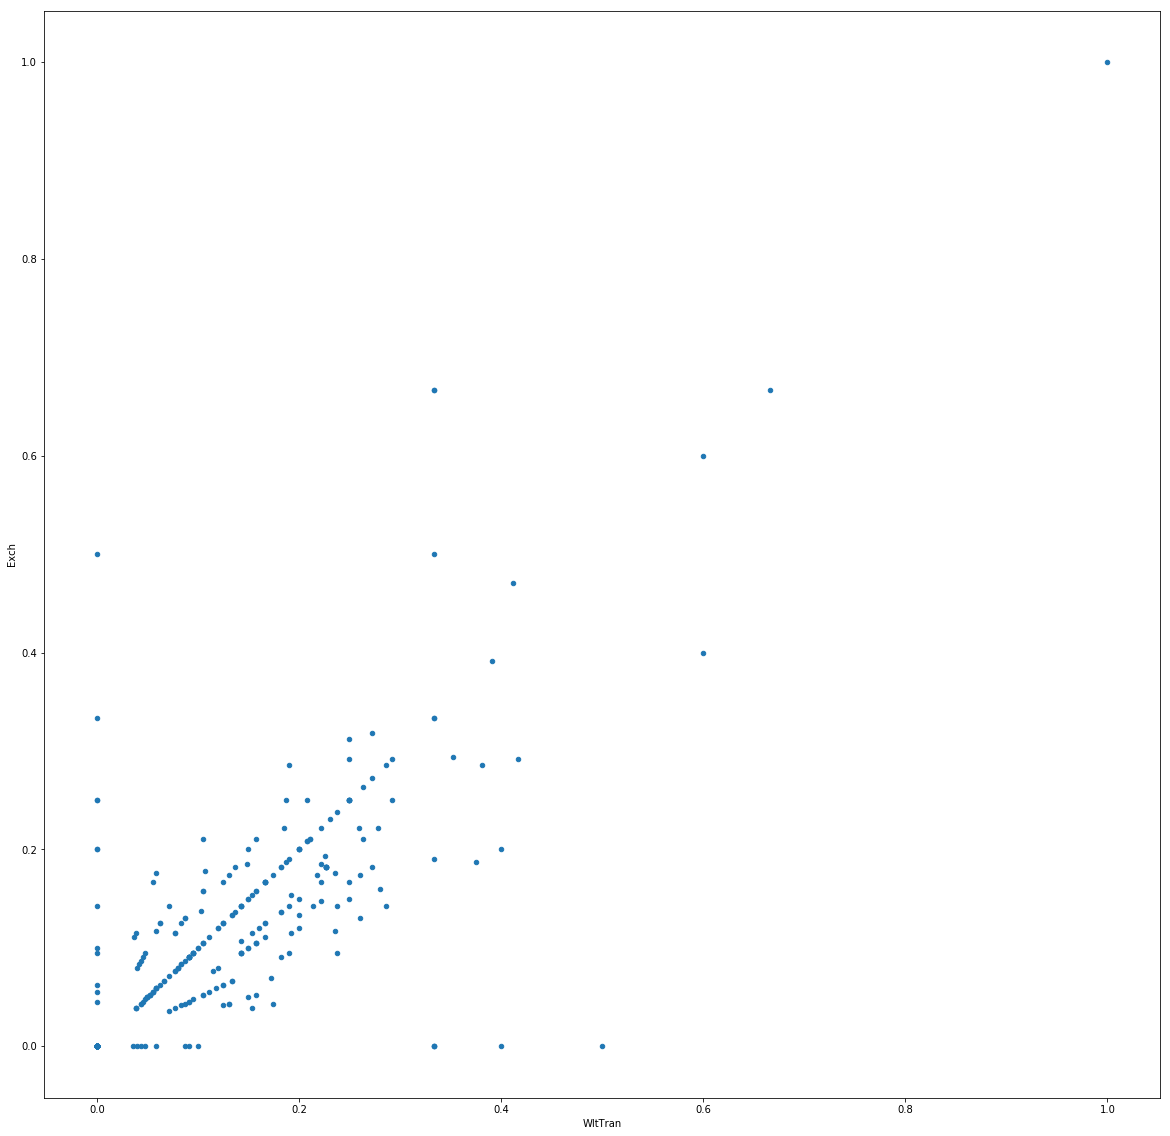

In [560]:
merger.iloc[merger.index>'2013'].plot.scatter('WltTran', 'Exch')